In [23]:
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
%matplotlib inline

# DESI modules required

In [13]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

* `$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [2]:
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY'] = os.path.join(basedir,'survey')
print(os.environ['DESISURVEY'])

/global/cscratch1/sd/forero/quicksurvey_example/survey


# Survey Plan
We create a list of tiles to be observed by running `surveyplan` and `surveysim` for 100 days worth of survey.

In [3]:
!time surveyplan --create --duration 100 --verbose --plots

INFO:utils.py:94:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephemerides.py:94:__init__: Loaded ephemerides from /global/cscratch1/sd/forero/quicksurvey_example/survey/ephem_2019-08-28_2024-07-13.fits for 2019-08-28 to 2024-07-13
INFO:schedule.py:612:initialize: Footprint contains 1154 pixels.
INFO:schedule.py:706:initialize: Starting Sep 2019 (completed 4/1781 nights)
INFO:schedule.py:706:initialize: Starting Oct 2019 (completed 34/1781 nights)
INFO:schedule.py:706:initialize: Starting Nov 2019 (completed 65/1781 nights)
INFO:schedule.py:706:initialize: Starting Dec 2019 (completed 95/1781 nights)
INFO:schedule.py:706:initialize: Starting Jan 2020 (completed 126/1781 nights)
INFO:schedule.py:706:initialize: Starting Feb 2020 (completed 157/1781 nights)
INFO:schedule.py:706:initialize: Starting Mar 2020 (completed 186/1781 nights)
INFO:schedule.py:706:initialize: Starting Apr 2020 (completed 217/1781 nights)
INFO:schedule.py:706:initialize: Starting May 202

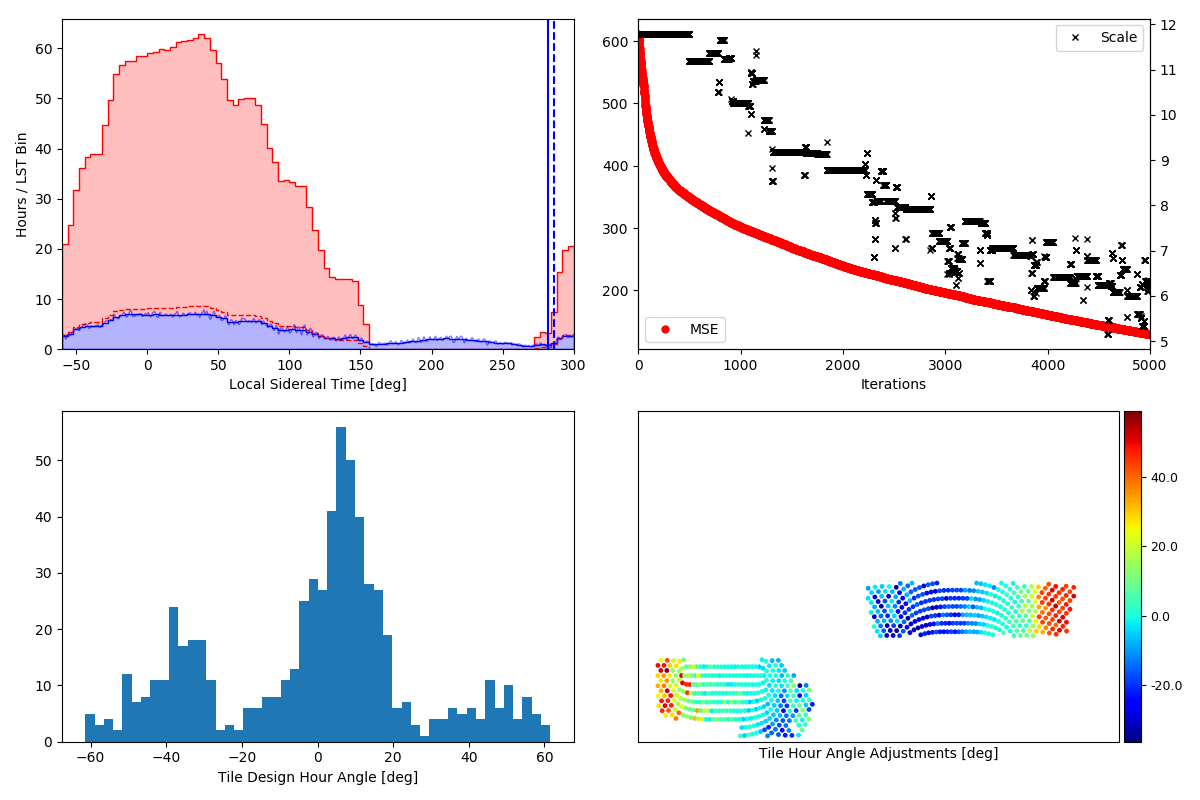

In [5]:
from IPython.display import Image
Image(filename=surveydir+'/plan_2019-08-28_DARK.png', width=800)

In [6]:
#!time surveysim --seed 123 --strategy HA+fallback --plan plan.fits --verbose

INFO:utils.py:94:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:weather.py:213:save: Saved weather to /global/cscratch1/sd/forero/quicksurvey_example/survey/weather_123.fits.
INFO:ephemerides.py:94:__init__: Loaded ephemerides from /global/cscratch1/sd/forero/quicksurvey_example/survey/ephem_2019-08-28_2024-07-13.fits for 2019-08-28 to 2024-07-13
INFO:simulator.py:100:__init__: Will simulate 2019-08-28 to 2024-07-13 with 0.0 / 16071 tiles completed.
INFO:simulator.py:124:next_day: Simulating 2019-08-28
INFO:nightops.py:106:nightOps: Selected DARK tile 1227 at 02:55:09.051322 with 30.0 s overhead.
INFO:nightops.py:131:nightOps: Clip exposure time 6649.2 s -> 60.0 min for tile 1227.
INFO:nightops.py:106:nightOps: Selected DARK tile 1239 at 04:01:26.851166 with 120.0 s overhead.
INFO:nightops.py:131:nightOps: Clip exposure time 13942.6 s -> 60.0 min for tile 1239.
INFO:nightops.py:106:nightOps: Selected DARK tile 1235 at 05:03:19.175432 with 120.0 s overhead.
INF

# Read exposures list
Select a subset of tiles in the NGC selected to have dark, gray, and bright while excluding bright twilight tiles since our sky model doesn't know about twilight yet.

In [17]:
tiles = desimodel.io.load_tiles()
explist = Table.read(surveydir+'/exposures.fits')
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

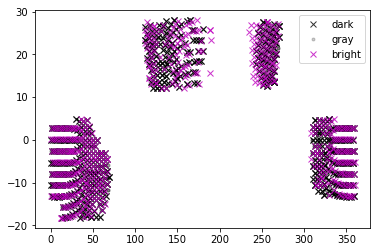

In [21]:
plt.plot(explist['ra'][isdark], explist['dec'][isdark], 'kx', alpha=0.8, label='dark')
plt.plot(explist['ra'][isgray], explist['dec'][isgray], 'k.', alpha=0.2, label='gray')
plt.plot(explist['ra'][isbright], explist['dec'][isbright], 'mx', alpha=0.8, label='bright')
plt.legend(loc='upper right')

Pick 5 tiles nearest RA=130, dec=18

In [24]:
ntiles = 5
xtiles = tiles[np.in1d(tiles['TILEID'], explist['tileid'])]
xyz = hp.ang2vec(xtiles['ra'], xtiles['dec'], lonlat=True)
center = hp.ang2vec(130, 18, lonlat=True)
d2 = ((xyz - center)**2).sum(axis=1)
ii = np.argsort(d2)[0:ntiles]
xtiles = xtiles[ii]
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, xtiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], xtiles['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(xtiles), nexp, len(pixels)))

5 tiles covered by 12 exposures and 58 healpixels


In [25]:
#- row indices of exposures of the selected tiles
iobs = np.where(np.in1d(explist['tileid'], xtiles['TILEID']))[0]
assert np.all(np.in1d(explist['tileid'][iobs], xtiles['TILEID']))
print(iobs)
explist[iobs]

[1407 1408 1409 1410 1513 1514 1791 1792 1798 2023 2024 2025]


tileid,pass,ra,dec,night,mjd,exptime,seeing,airmass,moonfrac,moonalt,moonsep
,,,,,,s,arcsec,,,deg,deg
int32,int16,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64
5326,0,131.95,18.03,2019-10-29,58786.4599208,1116.16574745,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.4742283,1199.5791279,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.4895012,1226.42659231,0.736597836018,1.28389484728,0.062178465933,-57.1211700439,118.981342038
5326,0,131.95,18.03,2019-10-29,58786.5050848,712.922147952,0.832010805607,1.11035391345,0.062178465933,-50.2612800598,119.416295871
5307,0,129.18,16.6,2019-11-02,58790.4357837,771.11894578,0.707128405571,1.32918633164,0.391961773564,-61.0216178894,171.15523817
5307,0,129.18,16.6,2019-11-02,58790.4460976,855.429854495,0.707128405571,1.32918633164,0.391961773564,-61.0216178894,171.15523817
28357,4,128.77,19.48,2019-11-21,58809.4736434,811.034636678,0.850808739662,1.03610391783,0.236458597303,22.8892936707,59.1188742326
28357,4,128.77,19.48,2019-11-21,58809.4844193,650.423255976,0.850808739662,1.03610391783,0.236458597303,22.8892936707,59.1188742326


In [27]:
print(pixels)

[4331 4335 4346 4347 4350 4629 4631 4637 4639 4661 4663 4669 4672 4673 4674
 4675 4676 4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689
 4690 4691 4692 4694 4696 4697 4698 4699 4700 4702 4704 4705 4706 4707 4708
 4709 4710 4711 4712 4713 4716 4717 4720 4721 4722 4723 4724 4728]


Plot the tiles and pixels

(13, 23)

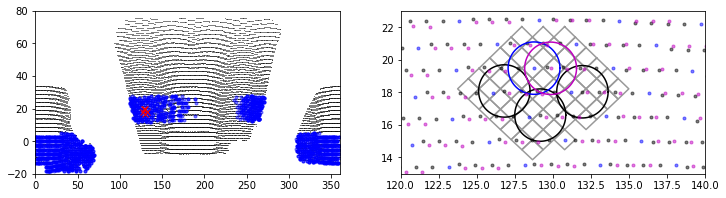

In [32]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plt.plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plt.plot(ra, dec, '-', color='0.6')

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plt.plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plt.plot(xtiles['RA'], xtiles['DEC'], 'rx')
plt.xlim(0,360); plt.ylim(-20, 80)

plt.subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plt.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

plt.xlim(120, 140); plt.ylim(13, 23)